In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import load_sample_image, make_blobs, load_files
import plotly.express as px
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import silhouette_samples, silhouette_score, classification_report, accuracy_score
import matplotlib.cm as cm
from numpy.random import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

# PART1

### Import dataset

In [2]:
dataset = pd.read_csv('glass.csv')
dataset = dataset.fillna(dataset.mean())
feature_names = list(dataset.columns[:-1])
dataset.head()

RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

### PCA decomposition

In [3]:
X = dataset[feature_names]
reduced_pca = PCA(n_components=2).fit_transform(X)

In [4]:
fig = px.scatter(reduced_pca,
                 x=0, y=1,
                 labels={
                     "0": "Principal component 0",
                     "1": "Principal component 1"
                        },
                 title = 'PCA plot',
                 color=dataset['Type']).update(layout = dict(title = dict(x = 0.5)))
fig.show()

### TSNE decomposition

In [5]:
reduced_tsne = TSNE(n_components=2).fit_transform(X)

In [6]:
fig = px.scatter(reduced_tsne,
                 x=0, y=1,
                 labels={
                     "0": "Principal component 0",
                     "1": "Principal component 1"
                        },
                 title = 'PCA plot',
                 color=dataset['Type']).update(layout = dict(title = dict(x = 0.5)))
fig.show()

# PART2

### Color Quantization using K-Means

In [7]:
def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [8]:
flower = load_sample_image('flower.jpg')

image shape: (427, 640, 3)


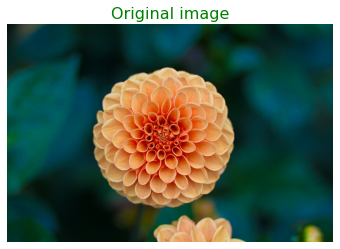

In [9]:
print('image shape:', flower.shape)
plt.axis('off')
plt.title(f'Original image', color='g',fontsize=16)
plt.imshow(flower)
plt.show()

In [10]:
n_colors = [64, 32, 16, 8]

In [11]:
flower = np.array(flower, dtype=np.float64) / 255

In [12]:
w, h, d = tuple(flower.shape)
image_array = np.reshape(flower, (w * h, d))

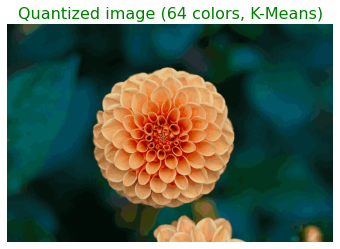

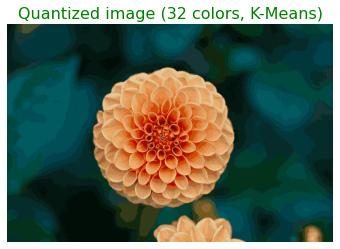

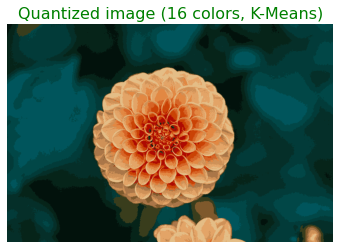

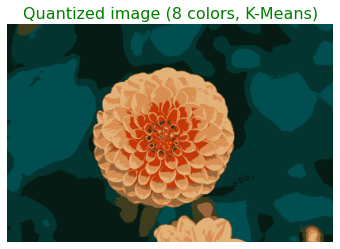

In [13]:
for it,n_color in enumerate(n_colors):
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = KMeans(n_clusters=n_color, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    plt.figure(it)
    plt.axis('off')
    plt.title(f'Quantized image ({n_color} colors, K-Means)', color='g',fontsize=16)
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

### Clustering Of Synthetic Data

In [14]:
centers = np.random.randint(3,5)
print(centers)
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=centers,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

4


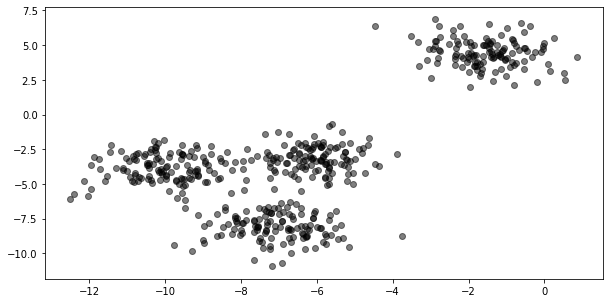

In [15]:
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color = 'black')
plt.show()

In [16]:
range_n_clusters = np.array([centers - 1, centers, centers + 1])

For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5745566973301872


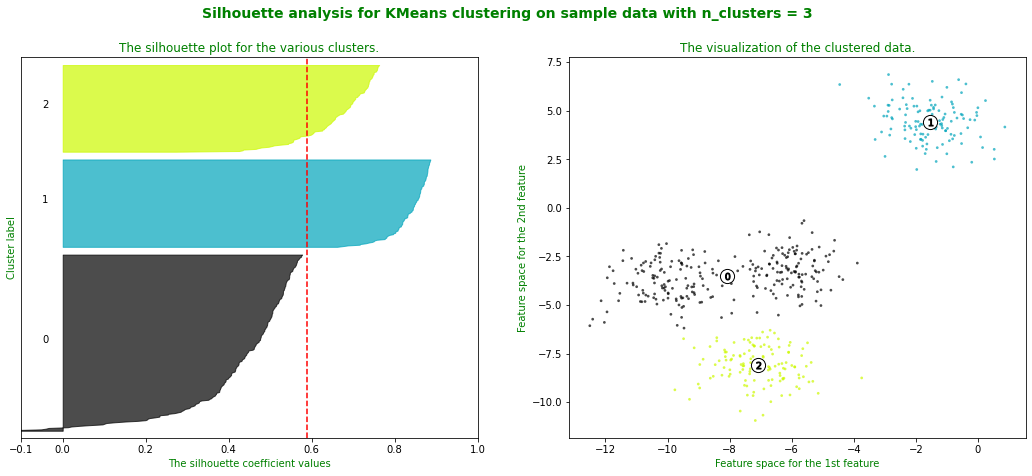

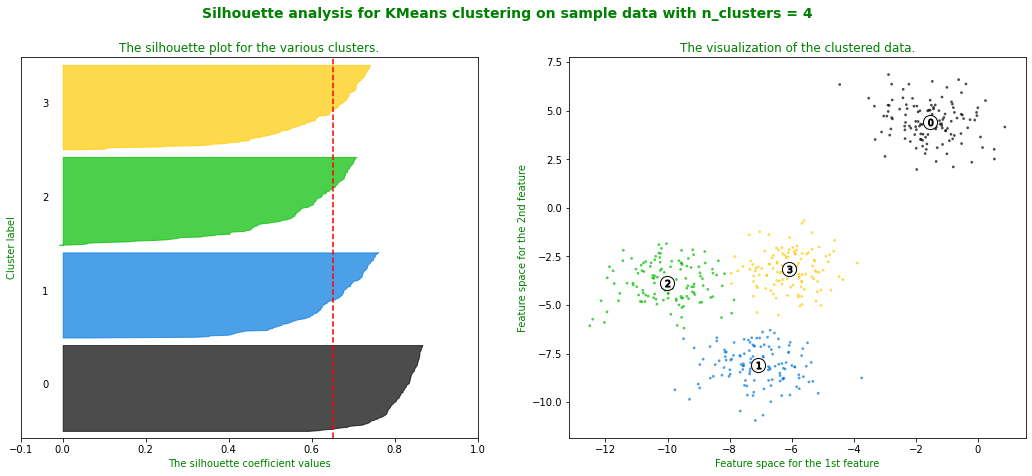

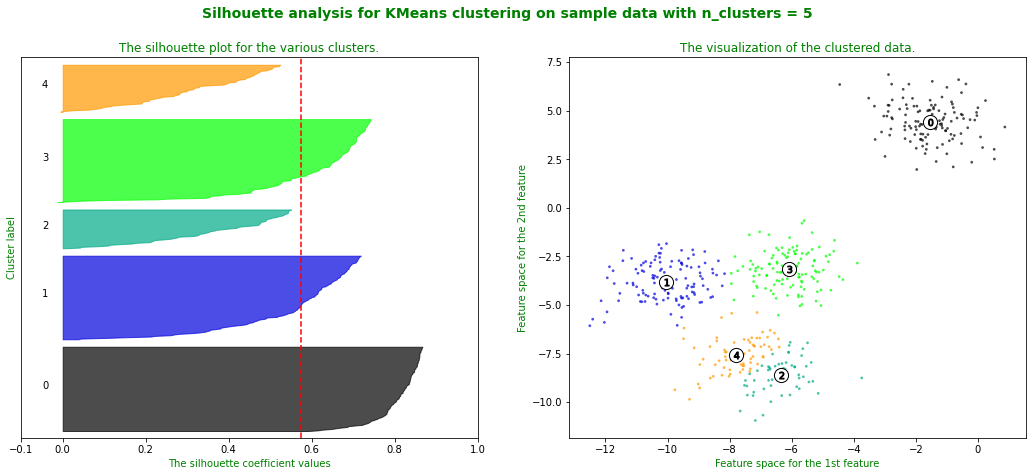

In [17]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # (b - a)/max(a, b)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 
    ax1.set_title("The silhouette plot for the various clusters.", color='g')
    ax1.set_xlabel("The silhouette coefficient values", color='g')
    ax1.set_ylabel("Cluster label", color='g')
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.", color='g')
    ax2.set_xlabel("Feature space for the 1st feature", color='g')
    ax2.set_ylabel("Feature space for the 2nd feature", color='g')
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters), color='g',
                 fontsize=14, fontweight='bold')

### EM Algorithm

In [18]:
mean1 = (1, 2)
cov1 = np.identity(2)
X1 = multivariate_normal(mean1, cov1, 200)
mean2 = (4, 5)
cov2 = 3*np.identity(2)
X2 = multivariate_normal(mean2, cov2, 200)
X = np.concatenate([X1, X2])

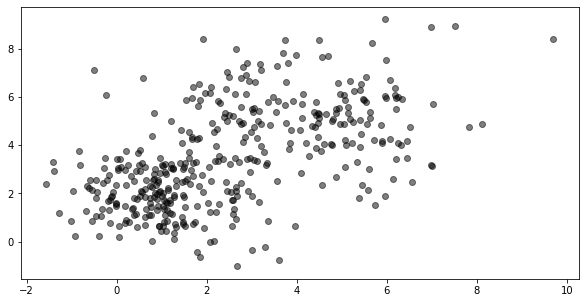

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, color = 'black')
plt.show()

In [20]:
clf = GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X)

GaussianMixture(n_components=2)

In [21]:
print('means\n',clf.means_)
print('weights\n',clf.weights_)
print('covariances\n',clf.covariances_)

means
 [[0.9635959  1.92907086]
 [4.05619406 5.12659129]]
weights
 [0.50963179 0.49036821]
covariances
 [[[ 1.07018894 -0.13560252]
  [-0.13560252  1.13019096]]

 [[ 2.9052887  -0.01031946]
  [-0.01031946  2.43085502]]]


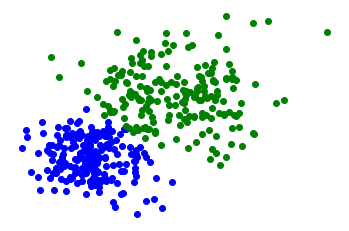

In [22]:
predicted = clf.predict(X)
color=['blue','green']
for k in range(0,2):
    data = X[predicted==k]
    plt.scatter(data[:,0],data[:,1],c=color[k])
plt.axis('off')
plt.show()

### NLP

In [23]:
movie_data = load_files(r"review_polarity/txt_sentoken/")
data, target = movie_data.data, movie_data.target

In [24]:
vectorizer = CountVectorizer(token_pattern=r'(?u)\b[a-zA-Z]\w+\b',
                             ngram_range=(1, 2),
                             max_features=1500,
                             min_df=5,
                             max_df=0.7,
                             stop_words='english',
                             lowercase=True)
X = vectorizer.fit_transform(data).toarray()

In [25]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=0)

In [27]:
classifier = RandomForestClassifier(n_estimators=1000, max_depth = 10, random_state=0)
classifier.fit(X_train, y_train) 

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=0)

In [28]:
y_pred = classifier.predict(X_test)

In [29]:
print(classification_report(y_test,y_pred))
print('accuracy:',accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       208
           1       0.78      0.89      0.83       192

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

accuracy: 0.8275


#### wordcloud

In [30]:
text = ' '.join(vectorizer.get_feature_names())
wordcloud = WordCloud(width = 3000,
                      height = 2000,
                      random_state=1,
                      background_color='salmon',
                      colormap='Pastel1',
                      collocations=False,
                      stopwords = STOPWORDS).generate(text)

(-0.5, 2999.5, 1999.5, -0.5)

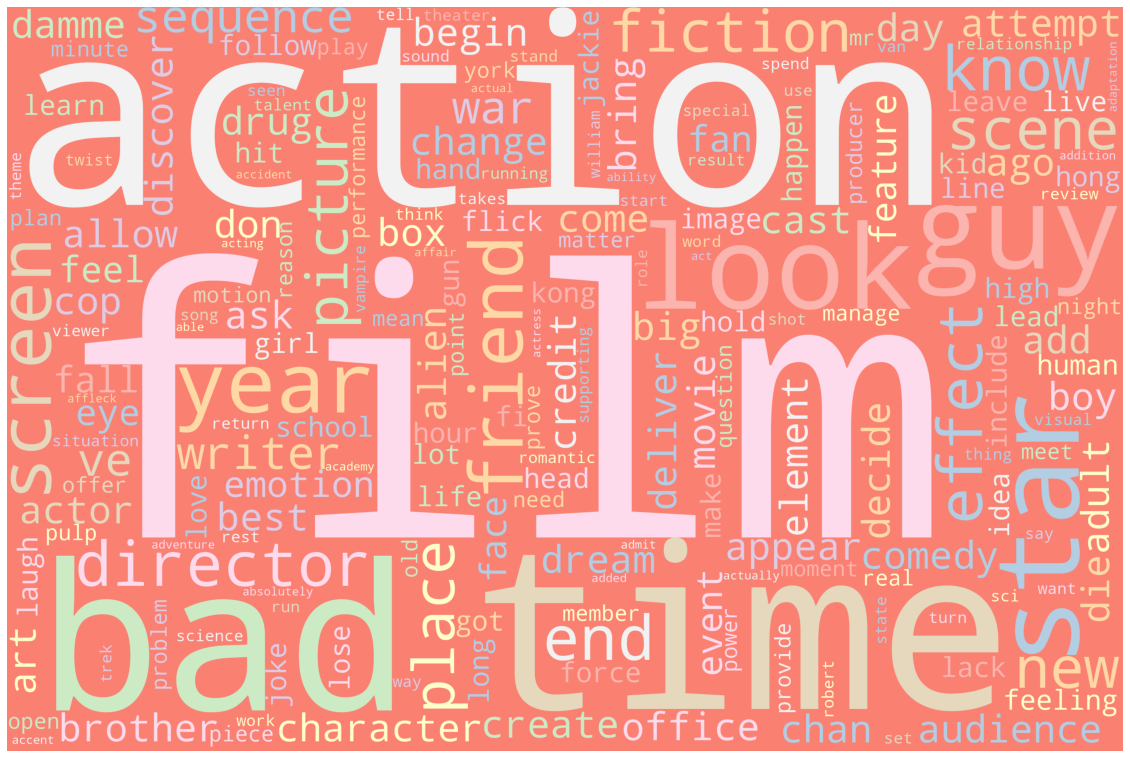

In [31]:
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud) 
plt.axis("off")